In [1]:
import openmc
import openmc.mgxs as mgxs
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
sp_flat = openmc.StatePoint('./flat_distr_gen0_64/statepoint.80.h5')

In [3]:
sp_flat_noflux = openmc.StatePoint('./flat_distr_gen0_64/noflux/statepoint.80.h5')

In [4]:
sp_minimized = openmc.StatePoint('./most_minimized_gen0_64/statepoint.80.h5')

In [5]:
sp_least_minimized = openmc.StatePoint('./least_minimized_gen1_128/statepoint.80.h5')

In [6]:
def get_fuel_normalized_fqro(mesh_tally_name, pf_index, pf_distr, sp):
    mesh_tally = sp.get_tally(name=mesh_tally_name)
    fqro = mesh_tally.get_slice(scores=['fission-q-recoverable'])
    fqro_list = fqro.mean
    fqro_list.shape = (5,10)
    fqro_array = np.array(fqro_list)
    normalized_array = fqro_array / pf_distr[pf_index]
    return normalized_array

def get_ppf_fuel(sp, pf_distr):
    huge_array = []
    for i in range(1, 6):
        huge_array.append(get_fuel_normalized_fqro("fqr_"+str(i), i-1, pf_distr, sp))
    ppf = np.max(huge_array) / np.mean(huge_array)
    return ppf

In [7]:
get_ppf_fuel(sp_flat_noflux, [[0.06]*10]*6)
# sp_minimized_gen0_64: 1.079492521861689
# sp_minimized_gen0_128: 1.087242485375202
# this is why it is not flatter, because ppf is higher. 

1.0790608624858156

In [8]:
def get_values(sp_file):
    tally_flux = sp_file.get_tally(name='flux')
    flux = tally_flux.get_slice(scores=['flux'])
    nu_fission = tally_flux.get_slice(scores=['nu-fission'])
    fission = tally_flux.get_slice(scores=['fission'])
    flux_conv_dict = {}
    eg_names = ['eg4', 'eg3', 'eg2', 'eg1']
    egs = [(1e-6, 1.8554), (1.8554, 2.9023e1), (2.9023e1, 9.1188e3), (9.1188e3, 2.0e7)]
    flux_eg, nu, nu_fiss_eg, fiss_eg = {}, {}, {}, {}
    for x in range(4):
        print(x)
        flux_eg[x] = flux.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        nu_fiss_eg[x] = nu_fission.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        fiss_eg[x] = fission.get_slice(
            filters=[
                openmc.EnergyFilter], filter_bins=[
                (egs[x],)])
        nu[x] = sum(nu_fiss_eg[x].mean) / sum(fiss_eg[x].mean)
    return flux_eg, nu, nu_fiss_eg, fiss_eg

In [9]:
flux_eg_flat, nu_flat, nu_fiss_flat, fiss_eg_flat = get_values(sp_flat)

0
1
2
3


In [10]:
flux_eg_minimized, nu_minimized, nu_fiss_minimized, fiss_eg_minimized = get_values(sp_minimized)

0
1
2
3


In [11]:
flux_eg_least_minimized, nu_least_minimized, nu_fiss_least_minimized, fiss_eg_least_minimized = get_values(sp_least_minimized)

0
1
2
3


In [12]:
def get_flux_dict_onethird(k, P, z_thickness, nu, flux_eg):
    Q = 200 * 1.6022e-13
    V = 40.52 * 23.4 * z_thickness / (100*100)
    flux_conv_dict = {}
    eg_names = ['eg4', 'eg3', 'eg2', 'eg1']
    for x in range(4):
        N = P * nu[x] / (Q * k)
        flux_conv_dict[eg_names[x]] = flux_eg[x].mean * 1 / V * N
        flux_conv_dict[eg_names[x]].shape = (100, 100)
        flux_conv_dict[eg_names[x]][np.isnan(flux_conv_dict[eg_names[x]])] = 0
    return flux_conv_dict

In [13]:
power_moltres = 8741 # 1cm thick
flux_vals_flat = get_flux_dict_onethird(sp_flat.k_combined.n, power_moltres, z_thickness=1, nu=nu_flat, flux_eg=flux_eg_flat)
flux_vals_minimized = get_flux_dict_onethird(sp_minimized.k_combined.n, power_moltres, z_thickness=1, nu=nu_minimized, flux_eg=flux_eg_minimized)
flux_vals_least_minimized = get_flux_dict_onethird(sp_least_minimized.k_combined.n, power_moltres, z_thickness=1, nu=nu_least_minimized, flux_eg=flux_eg_least_minimized)





In [14]:
def clear_zeros(flux_vals_eg):
    flux_vals_eg_cleared = []
    bot_left = [13.50, 0]
    top_left = [0, 23.4]
    bot_right = [40.53, 0]
    top_right = [27.02, 23.4]
    gradient = (bot_left[1] - top_left[1]) / (bot_left[0] - top_left[0]) 
    dy = top_left[1]/100
    y_100 = np.arange(bot_left[1]+top_left[1]/200, top_left[1]+top_left[1]/200, dy)
    c_right = top_right[1] - gradient * top_right[0]
    x_100_left = (y_100 - top_left[1]) / gradient
    x_100_right = (y_100 - c_right) / gradient
    dx = 40.53/100
    print(dx, dy)
    x_across = np.arange(0, 40.53, dx)
    for j in range(100):
        y = y_100[j]
        for i in range(100):
            x = x_across[i]
            if x > x_100_left[j]+dx/2 and x < x_100_right[j]-dx/2: 
                flux_vals_eg_cleared.append(flux_vals_eg[j][i])
    return flux_vals_eg_cleared

In [15]:
flux_vals_flat_cleared = {}
flux_vals_flat_cleared['eg1'] = clear_zeros(flux_vals_flat['eg1'])
flux_vals_flat_cleared['eg2'] = clear_zeros(flux_vals_flat['eg2'])
flux_vals_flat_cleared['eg3'] = clear_zeros(flux_vals_flat['eg3'])
flux_vals_flat_cleared['eg4'] = clear_zeros(flux_vals_flat['eg4'])

0.4053 0.23399999999999999
0.4053 0.23399999999999999
0.4053 0.23399999999999999
0.4053 0.23399999999999999


In [16]:
flux_vals_minimized_cleared = {}
flux_vals_minimized_cleared['eg1'] = clear_zeros(flux_vals_minimized['eg1'])
flux_vals_minimized_cleared['eg2'] = clear_zeros(flux_vals_minimized['eg2'])
flux_vals_minimized_cleared['eg3'] = clear_zeros(flux_vals_minimized['eg3'])
flux_vals_minimized_cleared['eg4'] = clear_zeros(flux_vals_minimized['eg4'])

0.4053 0.23399999999999999
0.4053 0.23399999999999999
0.4053 0.23399999999999999
0.4053 0.23399999999999999


In [17]:
flux_vals_least_minimized_cleared = {}
flux_vals_least_minimized_cleared['eg1'] = clear_zeros(flux_vals_least_minimized['eg1'])
flux_vals_least_minimized_cleared['eg2'] = clear_zeros(flux_vals_least_minimized['eg2'])
flux_vals_least_minimized_cleared['eg3'] = clear_zeros(flux_vals_least_minimized['eg3'])
flux_vals_least_minimized_cleared['eg4'] = clear_zeros(flux_vals_least_minimized['eg4'])

0.4053 0.23399999999999999
0.4053 0.23399999999999999
0.4053 0.23399999999999999
0.4053 0.23399999999999999


In [18]:
def plot_flux(group, flux_vals_flat_cleared, flux_vals_minimized_cleared, 
              flux_vals_flat, flux_vals_minimized):
    flux_flat = flux_vals_flat_cleared['eg'+str(group)]
    flux_minimized = flux_vals_minimized_cleared['eg'+str(group)]
    flat_max_min = max(flux_flat) / min(flux_flat)
    print("least: max, min",format(max(flux_flat),'.4E'), format(min(flux_flat),'.4E'))
    minimized_max_min = max(flux_minimized) / min(flux_minimized)
    print("mini: max, min",format(max(flux_minimized),'.4E'), format(min(flux_minimized),'.4E'))
    print("minimized, least: max/min", minimized_max_min, flat_max_min)
    print("min/least", minimized_max_min/flat_max_min)
    print("%", (minimized_max_min-flat_max_min)/flat_max_min*100)

    plt.figure()
    plt.imshow(flux_vals_minimized['eg'+str(group)],
               interpolation='none',origin='lower',cmap='viridis')
    plt.colorbar(pad=0.07)
    plt.xlabel("x [cm]", fontsize=16)
    plt.ylabel("y [cm]",  fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    bot_lim = min(min(flux_flat), min(flux_minimized))
    top_lim = max(max(flux_flat), max(flux_minimized))
    print("bot_lim, top_lim", format(bot_lim,'.4E'), format(top_lim,'.4E'))
    plt.clim(bot_lim, top_lim)
    plt.title("Most-Minimized $PPF_{fuel}$ = 1.0872, EG "+str(group))
    plt.savefig("flux-comparison-a-1c-most-minimized-grp"+str(group)+".png",bbox_inches='tight')
    
    plt.figure()
    plt.imshow(flux_vals_flat['eg'+str(group)],
               interpolation='none',origin='lower',cmap='viridis')
    plt.colorbar()
    plt.xlabel("x [cm]", fontsize=16)
    plt.ylabel("y [cm]",  fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.clim(bot_lim, top_lim)
    plt.title("Highest $PPF_{fuel}$ = 1.2431, EG "+str(group))
    plt.savefig("flux-comparison-a-1c-least-minimized-grp"+str(group)+".png",bbox_inches='tight')
    return
    

least: max, min 1.1236E+14 4.3083E+13
mini: max, min 9.0554E+13 4.9605E+13
minimized, least: max/min 1.8255096608814225 2.608041781974555
min/least 0.6999541470149779
% -30.004585298502214
bot_lim, top_lim 4.3083E+13 1.1236E+14


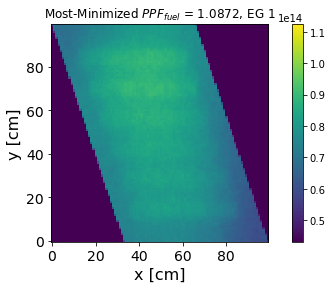

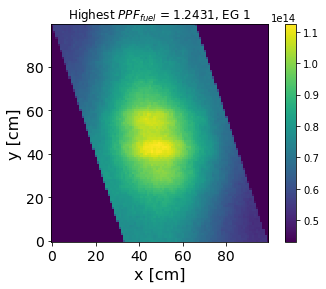

In [19]:
plot_flux(1, flux_vals_least_minimized_cleared, flux_vals_minimized_cleared, 
          flux_vals_least_minimized, flux_vals_minimized)

least: max, min 7.5978E+13 5.4816E+13
mini: max, min 7.4703E+13 5.5668E+13
minimized, least: max/min 1.3419430475479492 1.3860598252342455
min/least 0.9681710869306521
% -3.182891306934786
bot_lim, top_lim 5.4816E+13 7.5978E+13


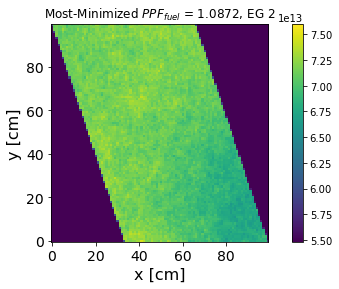

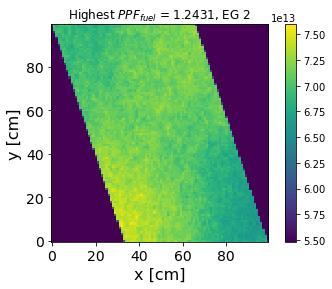

In [20]:
plot_flux(2, flux_vals_least_minimized_cleared, flux_vals_minimized_cleared, 
          flux_vals_least_minimized, flux_vals_minimized)

least: max, min 3.5305E+13 2.6452E+13
mini: max, min 3.4043E+13 2.6142E+13
minimized, least: max/min 1.3022348303040179 1.3346886960067648
min/least 0.9756843181486101
% -2.431568185138986
bot_lim, top_lim 2.6142E+13 3.5305E+13


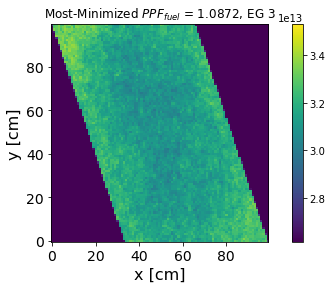

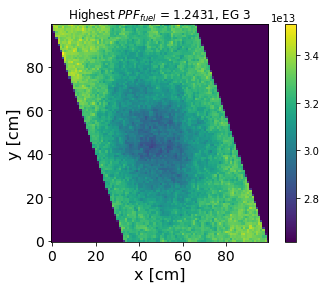

In [21]:
plot_flux(3, flux_vals_least_minimized_cleared, flux_vals_minimized_cleared, 
          flux_vals_least_minimized, flux_vals_minimized)

least: max, min 3.3916E+14 2.5480E+14
mini: max, min 3.1825E+14 2.4114E+14
minimized, least: max/min 1.319779433836559 1.3310945052492502
min/least 0.9914994229424962
% -0.85005770575039
bot_lim, top_lim 2.4114E+14 3.3916E+14


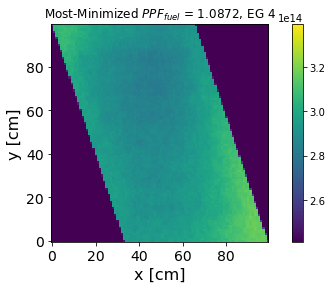

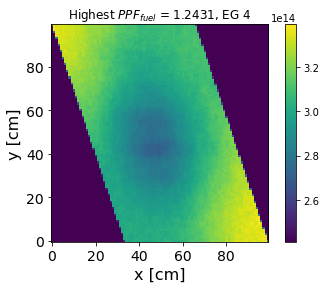

In [22]:
plot_flux(4, flux_vals_least_minimized_cleared, flux_vals_minimized_cleared, 
          flux_vals_least_minimized, flux_vals_minimized)

In [23]:
def plot_flux_comparisons(group, flux_vals_flat, flux_minimized, name):
    y = np.arange(0, 23.4, 23.4/100)
    flux_flat = flux_vals_flat["eg"+str(group)][:,50]
    flux_minimized = flux_vals_minimized["eg"+str(group)][:,50]
    perc_diff = list((flux_minimized-flux_flat) /flux_flat * 100)
    abs_perc_diff = list(abs(np.array(perc_diff)))
    max_val = max(abs_perc_diff)
    max_index = abs_perc_diff.index(max_val)
    print(perc_diff[max_index], max_index)
    norm_2 = np.linalg.norm(np.array(perc_diff))/len(flux_minimized)
    print(norm_2)
    print("flat: max/min", max(flux_flat)/ min((flux_flat)))
    print("minimized: max/min", max(flux_minimized)/ min((flux_minimized)))
    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(y, flux_flat, label='flat')
    ax.plot(y , flux_minimized, label='minimized')
    handles, labels = ax.get_legend_handles_labels()
    if group == 4:
        y = 0.3
    else:
        y = 1
    ax.legend(handles, labels, bbox_to_anchor=(1, y), fontsize=14)
    ax.set_xlabel('y [cm]', fontsize=16)
    ax.set_ylabel(r'Flux [$n/cm^2s$]', fontsize=16)
    #ax.set_ylim(0, 2e14)
    #ax.set_ylim(2e13, 2.2e14)
    ax.set_yscale('log')
    ax.set_xlim(0, 23.4)
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax.set_yticks([0.2e14, 0.4e14, 0.6e14, 0.8e14, 1e14, 1.2e14, 1.4e14, 1.6e14, 1.8e14, 2e14, 2.2e14])
    ax.set_title('Group '+str(group), fontsize=16)
    ax.grid()
    #plt.savefig(name)

-25.646812861154 41
1.3021194828572416
flat: max/min 1.5207513391623437
minimized: max/min 1.2152016318280816


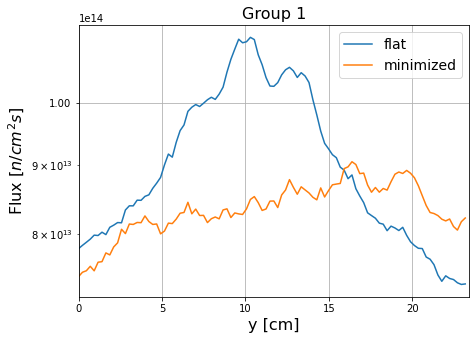

In [24]:
plot_flux_comparisons(1, flux_vals_least_minimized, flux_vals_minimized, 'flux_group1_948K_assem')

-7.468883173345392 86
0.42371310765358905
flat: max/min 1.1426584810872211
minimized: max/min 1.059871167002493


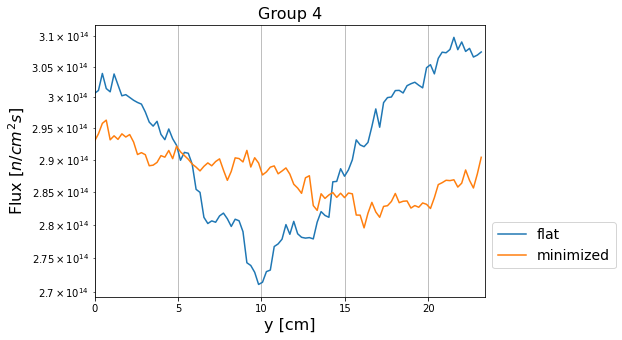

In [25]:
plot_flux_comparisons(4, flux_vals_least_minimized, flux_vals_minimized, 'flux_group1_948K_assem')